In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt

In [2]:
def align_reads(reads, kmer):
    '''
        Takes in a list of reads for one kmer and modifies them to be aligned to the kmer.
    ''' 
    locs = []
    lens = []
    for read in reads:
        locs.append(read.index(kmer))

    max_bases_before = max(locs)
    for i in range(len(reads)):
        reads[i] = '-' * (max_bases_before - locs[i]) + reads[i]
        lens.append(len(reads[i]))

    max_bases_after = max(lens) - len(kmer) - max_bases_before
    for i in range(len(reads)):
        bases_after = max_bases_after - (lens[i] - len(kmer) - max_bases_before)
        read = reads[i]
        reads[i] = read[0:max_bases_before] + read[max_bases_before + len(kmer):] + '-' * bases_after

In [3]:
def create_snp(reads):
    '''
        Create snp from reads.
    '''
    snp = None
    for col in range(len(reads[0])):
        snp_col = []
        vals = []
        for read in reads:
            if read[col] == '-' or not read[col] in 'ACGT':
                snp_col.append(-1)
            else:
                if read[col] not in vals:
                    vals.append(read[col])
                snp_col.append(vals.index(read[col]))
        snp_col = np.array(snp_col)
        snp_col.shape = [len(snp_col), 1]

        if snp is not None:
            snp = np.concatenate((snp, snp_col), axis=1)
        else:
            snp = snp_col

#     print(snp)
    
    return snp

In [4]:
def calculate_m(snp, threshold):
    '''
        Calculates number of mutation columns and sample size from snp.
    '''
    m = 0
    for col in range(snp.shape[1]):
        snp_col = snp[:, col]
        alleles_present = len(snp_col) - np.count_nonzero(snp_col == -1)

        if alleles_present / len(snp_col) >= threshold:
            if np.count_nonzero(snp_col > 0) > 0:
                m += 1

    return (m)

In [5]:
def estimate_theta(m, n):
    '''
        Calculates Watterson's estimate of theta given m = number of mutation columns and n = size of sample.
    '''
    # Watterson estimate of theta
    theta = m / math.log(n)
    return theta

In [ ]:
num_individuals = 20
indiv_files = []
num_lines = len(open("genome_skimming_indivkmerDictFiles/indiv_0.fa_kmerDict.txt").readlines())
# num_lines = len(open("rad_initio_indivkmerDictFiles/msp_00.1.fa_kmerDict.txt").readlines())
print("Number of lines in indiv file:", num_lines)
for i in range(num_individuals):
#     individual = math.floor(i / 2)
#     sample_num = (i % 2) + 1
#     new_file = open("rad_initio_indivkmerDictFiles/msp_0" + str(individual) + "." + str(sample_num) + ".fa_kmerDict.txt")
    new_file = open("genome_skimming_indivkmerDictFiles/indiv_" + str(i) + ".fa_kmerDict.txt")
    indiv_files.append(new_file)

snp = np.array([[]] * 20)
    
coverages = []
total_m = 0
for i in range(num_lines):
    kmer = ""
    contigs = []
    for i in range(num_individuals):
        line = next(indiv_files[i])
        splitline = line.strip().split("\t")
        if len(splitline) == 2:
            if (len(kmer) > 0):
                assert(kmer == splitline[0])
            else:
                kmer = splitline[0]
            
            contigs.append(splitline[1])
    
    coverages.append(len(contigs))
    # Only counting kmers with coverage of 20
    if len(contigs) < 20:
        continue
        
    # Align contigs by kmer
    align_reads(contigs, kmer)
    
    # Create snp
    new_snp = create_snp(contigs)

    # Get m and add to total
    total_m += calculate_m(new_snp, 0.6)
    
#     if snp == None:
#         snp = new_snp
#     else:
    snp = np.concatenate([snp, new_snp], axis=1)
#     print('Total m:', total_m)
    
# estimate theta with all individuals
theta_estimate = estimate_theta(total_m, num_individuals)

print("Total m:", total_m)
print("Theta estimate:", theta_estimate)

Number of lines in indiv file: 10599778


(array([8281082.,  967093.,  373215.,  223471.,  157197.,  123675.,
         110939.,  116415.,  137047.,  109644.]),
 array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18., 20.]),
 <a list of 10 Patch objects>)

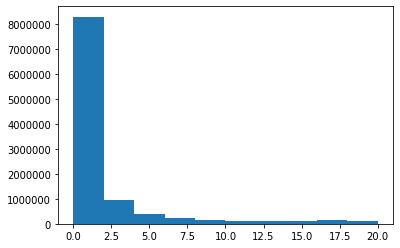

In [7]:
plt.hist(coverages)

In [11]:
arr1 = np.array([[1, 2], [3, 4]])
arr2 = np.array([[5], [6]])
arr3 = np.concatenate([arr1, arr2], axis=1)
print(arr3)

[[1 2 5]
 [3 4 6]]
